## Drone live face recognition.

In [21]:
import pandas as pd
import numpy as np
import os
import warnings
import cv2
from sklearn.model_selection import train_test_split
# Note, using tf model instead of sklearn model
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

warnings.filterwarnings("ignore")
faces_ = pd.read_csv("./faces.csv")

print("TensorFlow version:", tf.__version__)
print("Numpy version:", np.__version__)
print("Physical devices:", tf.config.list_physical_devices())
print("GPU devices:", tf.config.list_physical_devices('GPU'))
print("NumPy version:", np.__version__)
print("Matplotlib version:", plt.matplotlib.__version__)

TensorFlow version: 2.20.0
Numpy version: 2.2.6
Physical devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
NumPy version: 2.2.6
Matplotlib version: 3.10.8


In [22]:
faces_.head()


,image_name,width,height,x0,y0,x1,y1
0,00001722.jpg,1333,2000,490,320,687,664
1,00001044.jpg,2000,1333,791,119,1200,436
2,00001050.jpg,667,1000,304,155,407,331
3,00001736.jpg,626,417,147,14,519,303
4,00003121.jpg,626,418,462,60,599,166


In [23]:
faces_.columns

Index(['image_name', 'width', 'height', 'x0', 'y0', 'x1', 'y1'], dtype='object')

In [24]:
is_dup = faces_["image_name"].value_counts()
print(is_dup)
duplicated_values = is_dup[is_dup > 1].index.tolist()
print(f"\nValues that are duplicated: {len(duplicated_values)}")

image_name
00000657.jpg    12
00003165.jpg    11
00003172.jpg    11
00000508.jpg    10
00000593.jpg     9
                ..
00002712.jpg     1
00000105.jpg     1
00002921.jpg     1
00003381.jpg     1
00002276.jpg     1
Name: count, Length: 2204, dtype: int64

Values that are duplicated: 491


## Create a map of image paths with width, height, x0, y0, x1, y1
Above showed about 400 duplicate values

In [25]:
data = {}
for i in faces_['image_name']:
    if i not in data:
        data[i] = []

for index, image_name in enumerate(faces_["image_name"]):
    width = faces_["width"][index]
    height = faces_["height"][index]
    x0 = faces_["x0"][index]
    y0 = faces_["y0"][index]
    x1 = faces_["x1"][index]
    y1 = faces_["y1"][index]
    new_x0 = int((x0/width)*224)
    new_y0 = int((y0/height)*224)
    new_x1 = int((x1/width)*224)
    new_y1 = int((y1/height)*224)
    data[image_name].append(new_x0)
    data[image_name].append(new_y0)
    data[image_name].append(new_x1)
    data[image_name].append(new_y1)


print(data)
print(len(data))

{'00001722.jpg': [82, 35, 115, 74], '00001044.jpg': [88, 19, 134, 73], '00001050.jpg': [102, 34, 136, 74], '00001736.jpg': [52, 7, 185, 162], '00003121.jpg': [165, 32, 214, 88, 113, 84, 157, 136, 12, 38, 57, 90, 90, 50, 134, 100, 59, 63, 109, 121], '00000400.jpg': [55, 34, 140, 135], '00002571.jpg': [27, 49, 73, 103, 139, 63, 180, 110], '00000366.jpg': [42, 32, 125, 130, 75, 0, 159, 53], '00002565.jpg': [42, 12, 170, 161], '00001939.jpg': [71, 30, 140, 110], '00001087.jpg': [88, 8, 134, 61], '00001093.jpg': [79, 4, 106, 36], '00001905.jpg': [50, 10, 144, 122], '00001911.jpg': [89, 90, 125, 131, 109, 53, 161, 114, 65, 20, 116, 79], '00002997.jpg': [68, 93, 92, 121, 94, 8, 122, 41, 144, 43, 173, 76], '00003451.jpg': [82, 29, 124, 76], '00001246.jpg': [78, 17, 134, 84], '00001520.jpg': [139, 76, 201, 148, 6, 59, 70, 133, 76, 85, 138, 155, 99, 73, 162, 145, 186, 65, 223, 136], '00002029.jpg': [96, 28, 134, 71], '00003337.jpg': [77, 3, 112, 44, 78, 98, 111, 136, 10, 133, 36, 163], '00003323

In [26]:
img_dir = os.listdir('./images')
images = []
for img_name in data.keys():
    for itr in img_dir:
        if img_name == itr:
            img_arr = cv2.imread(os.path.join('./images', img_name), cv2.IMREAD_GRAYSCALE)
            img_resize = cv2.resize(img_arr, (224, 224))
            images.append(img_resize)

In [27]:
images = np.array(images)
print(images.shape)

images = np.expand_dims(images, axis=3)
print(images.shape)

(2204, 224, 224)
(2204, 224, 224, 1)


## Show some images

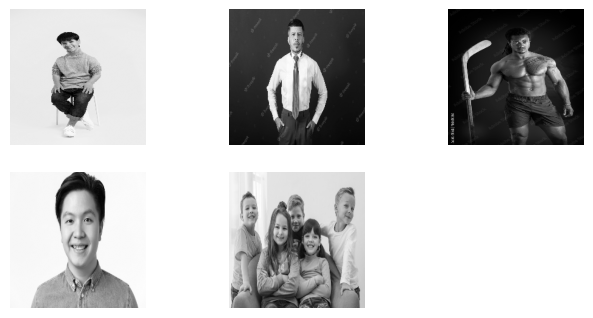

In [28]:
def plot_image(images, index=-1):
    plt.figure(figsize=(8,6))
    if index == -1:
        for i in range(5):
            plt.subplot(3,3,i+1)
            plt.imshow(images[i], cmap='gray')
            plt.axis('off')
    else:
        plt.subplot(3, 3, 1)
        plt.imshow(images[index], cmap="gray")
        plt.axis('off')


plot_image(images, -1)

## Create bbox or bounding box for object detection
Creating the bbox by first appending all arrays of N lengths to bbox
Find the maximum number of faces possible for any image i.e 12
Initilize a np array of zeros with a shape(images_len, max_bbox, COCO)
Normalize y_labels

In [29]:
# Create a bbox array in order with data Dataframe
bbox = []
for i in data.keys():
    bbox.append(data[i])

# Find the maximum number of faces AKA bbox for each image
# Since arrays can vary from [.,.,.,., * 4]
max_bbox = 0
for i in range(len(bbox)):
    max_bbox = max(max_bbox, len(bbox[i]))

y_label = np.zeros((len(data.keys()), int(max_bbox // 4), 5))
for i in range(len(bbox)):
    if int(max_bbox) - len(bbox[i]) != 0:
        reshape_cord = np.array(bbox[i]).reshape(-1,4)
        num_boxes = reshape_cord.shape[0]
        y_label[i, :num_boxes, :4] = reshape_cord
        y_label[i, :num_boxes, 4] = 1.0

y_label[..., :4] = y_label[...,:4]/224.0
images = images/255.0

In [30]:
print(y_label.shape)
print(images.shape)
print(y_label[0])

(2204, 12, 5)
(2204, 224, 224, 1)
[[0.36607143 0.15625    0.51339286 0.33035714 1.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]]


In [31]:
X_train, X_test, y_train, y_test = train_test_split(images, y_label, test_size=0.2, random_state=42)

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Reshape, Flatten, Input

# Regression model for cordinate prediction.
model = Sequential([
    # Block 1
    Conv2D(32, 3, input_shape=(224,224,1), padding="same", activation="relu"),
    BatchNormalization(),
    MaxPool2D(pool_size=2),
    
    # Block 2
    Conv2D(64, 3, padding="same", activation="relu"),
    BatchNormalization(),
    MaxPool2D(pool_size=2),
    
    # Block 3
    Conv2D(128, 3, padding="same", activation="relu"),
    BatchNormalization(),
    MaxPool2D(pool_size=2),

    # Transition to Dense
    GlobalAveragePooling2D(), # Replaces Flatten for better generalization
    
    Dense(512, activation="relu"),
    Dropout(0.5),
    Dense(256, activation="relu"),
    
    # Final Layer
    Dense((int(max_bbox//4) * 5), activation="sigmoid"),
    Reshape((int(max_bbox//4), 5))
])

model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 224, 224, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 60)             │        15,420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 12, 5)          │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 306,364 (1.17 MB)

 Trainable params: 305,916 (1.17 MB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
""" 
    Custom function for new col in y_label
    
"""

def custom_detection_loss(y_true, y_pred):
    # y_true/y_pred shape: (Batch, 12, 5)
    
    # 1. Separate Coordinates and Confidence
    true_boxes = y_true[..., :4]  # (Batch, 12, 4)
    true_conf = y_true[..., 4]    # (Batch, 12)
    
    pred_boxes = y_pred[..., :4]  # (Batch, 12, 4)
    pred_conf = y_pred[..., 4]    # (Batch, 12)
    
    # 2. Confidence Loss (Objectness)
    # We use 'binary_crossentropy' but must ensure it doesn't reduce the 12 dimension yet
    conf_loss = tf.keras.metrics.binary_crossentropy(true_conf, pred_conf) # Result: (Batch,)
    
    # 3. Coordinate Loss (Localization)
    # Calculate MSE per box: (Batch, 12)
    coord_diff = tf.reduce_sum(tf.square(true_boxes - pred_boxes), axis=-1)
    
    # Only count loss for boxes that actually exist (where true_conf is 1)
    masked_coord_loss = coord_diff * true_conf
    
    # Sum the coordinate losses for all 12 slots and average by batch
    total_coord_loss = tf.reduce_mean(tf.reduce_sum(masked_coord_loss, axis=-1))
    
    # Return the combined mean loss
    return tf.reduce_mean(conf_loss) + (total_coord_loss * 5.0)

In [ ]:
batches_per_epoch = len(X_train)
lr_decay = (1./0.75 -1)/batches_per_epoch
model.compile(loss=custom_detection_loss, optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, decay=lr_decay), metrics=['accuracy', 'mae'])
his = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50)



Epoch 1/100


2026-01-04 20:47:59.750658: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 353841152 exceeds 10% of free system memory.


Confidence loss Tensor("compile_loss/custom_detection_loss/Mean:0", shape=(None,), dtype=float32)
Confidence loss Tensor("compile_loss/custom_detection_loss/Mean:0", shape=(None,), dtype=float32)
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.2282 - loss: 2.1257 - mae: 0.4513Confidence loss Tensor("compile_loss/custom_detection_loss/Mean:0", shape=(None,), dtype=float32)
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 102ms/step - accuracy: 0.2282 - loss: 1.7815 - mae: 0.4409 - val_accuracy: 0.5017 - val_loss: 2.2292 - val_mae: 0.4663
Epoch 2/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.2133 - loss: 1.3528 - mae: 0.4081 - val_accuracy: 0.5344 - val_loss: 1.8773 - val_mae: 0.4532
Epoch 3/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.2151 - loss: 1.1811 - mae: 0.3812 - val_accuracy: 0.4157 - val_loss: 1.5197 - val_mae: 0.4306
Epoch 4/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.2080 - loss: 1.1117 - mae: 0.3689 - val_accuracy: 0.3466 - val_loss: 1.3018 - val_m

KeyboardInterrupt: 

In [ ]:
model.evaluate(X_test, y_test, batch_size=32)

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.1272 - loss: 0.8388 - mae: 0.3323


[0.8388388156890869, 0.12717309594154358, 0.33231809735298157]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 594ms/step
0.5683763 0.14227875 0.7567437 0.3946205 0.99986327
Slot 0 - Box: [127.0, 31.0, 169.0, 88.0] Conf: 1.00


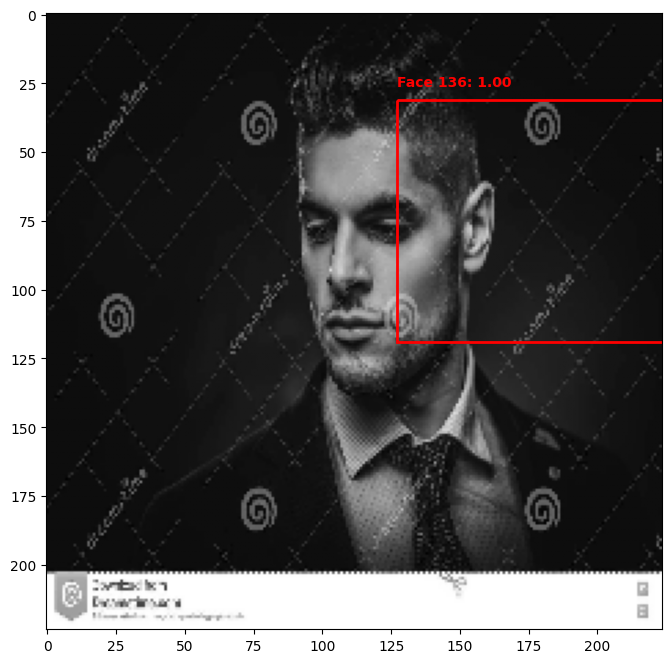

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
0.3993207 0.13500355 0.7068209 0.5302093 0.99997663
Slot 0 - Box: [89.0, 30.0, 158.0, 118.0] Conf: 1.00


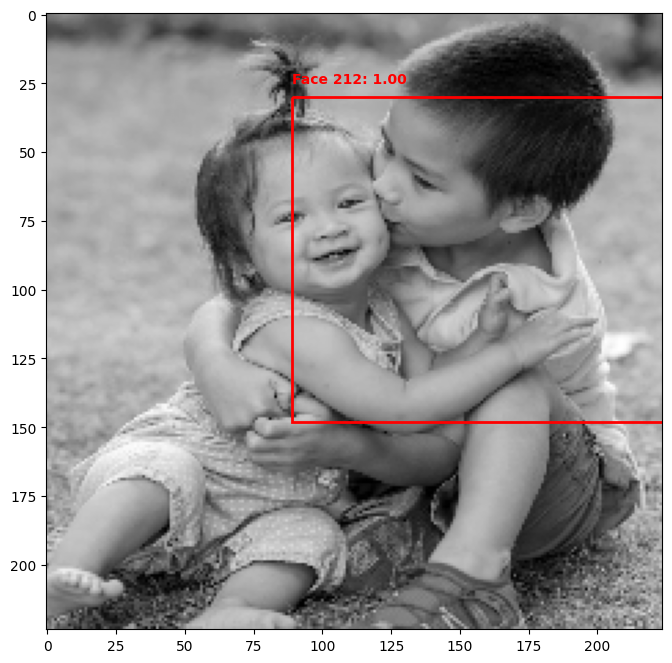

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
0.5421942 0.18459779 0.599546 0.32048073 0.9982029
Slot 0 - Box: [121.0, 41.0, 134.0, 71.0] Conf: 1.00


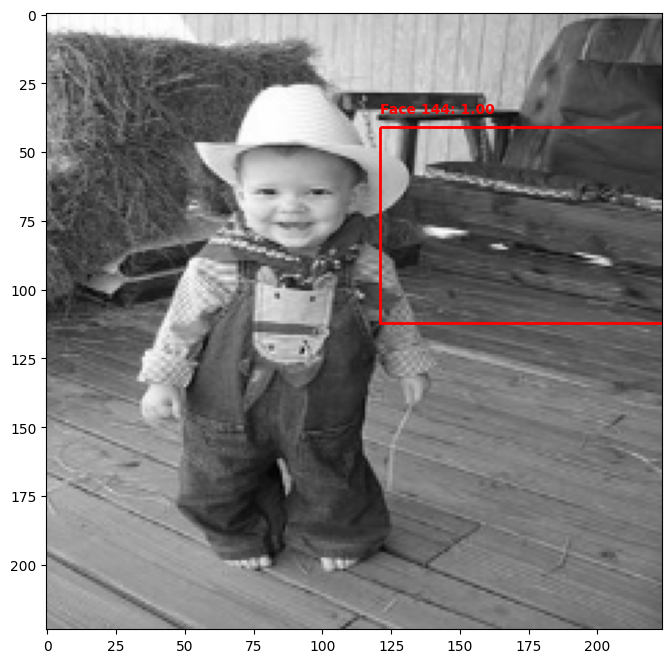

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
0.37887973 0.3133546 0.5933035 0.5050294 0.9961249
Slot 0 - Box: [84.0, 70.0, 132.0, 113.0] Conf: 1.00


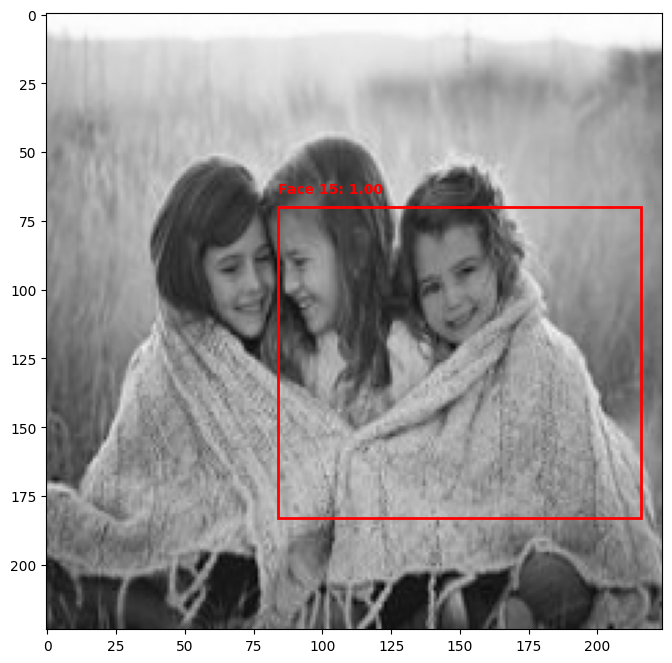

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
0.5483409 0.35438842 0.62558544 0.40465257 0.9885409
Slot 0 - Box: [122.0, 79.0, 140.0, 90.0] Conf: 0.99


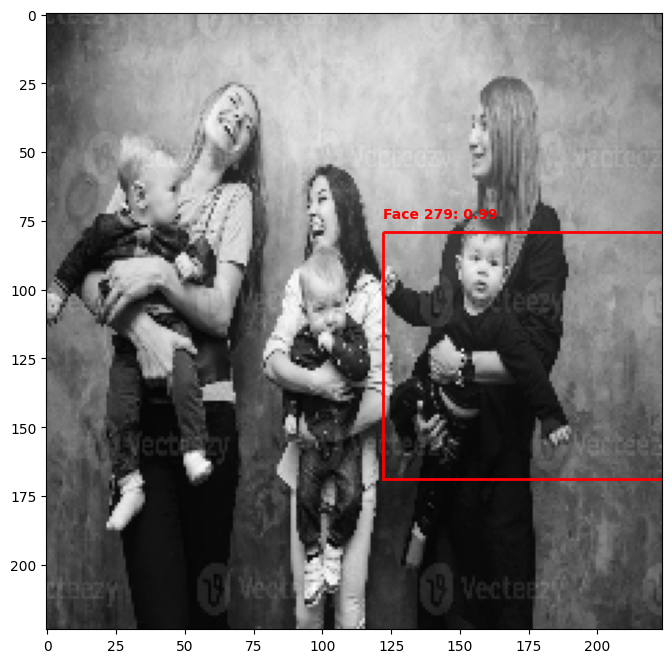

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
0.36769682 0.08947206 0.8523033 0.67179364 0.99999833
Slot 0 - Box: [82.0, 20.0, 190.0, 150.0] Conf: 1.00


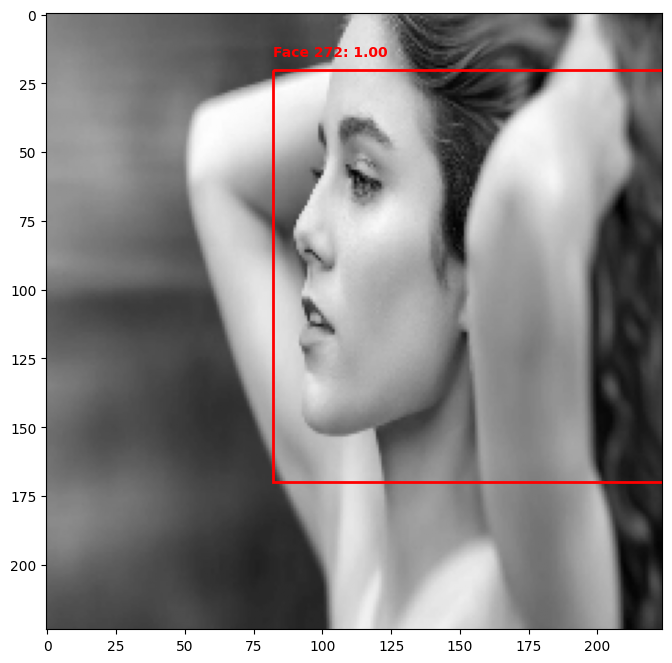

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
0.3812318 0.25317395 0.6334888 0.51261073 0.99975723
Slot 0 - Box: [85.0, 56.0, 141.0, 114.0] Conf: 1.00


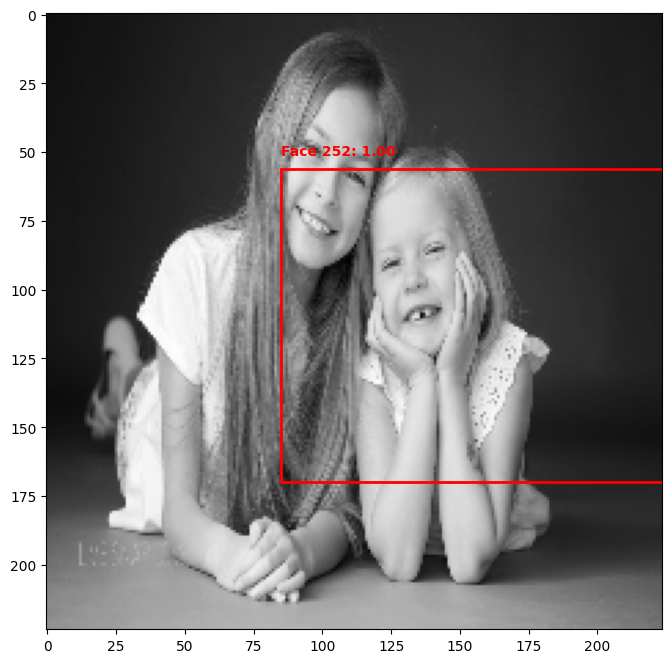

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
0.4087368 0.26768622 0.6443796 0.5146544 0.99925417
Slot 0 - Box: [91.0, 59.0, 144.0, 115.0] Conf: 1.00


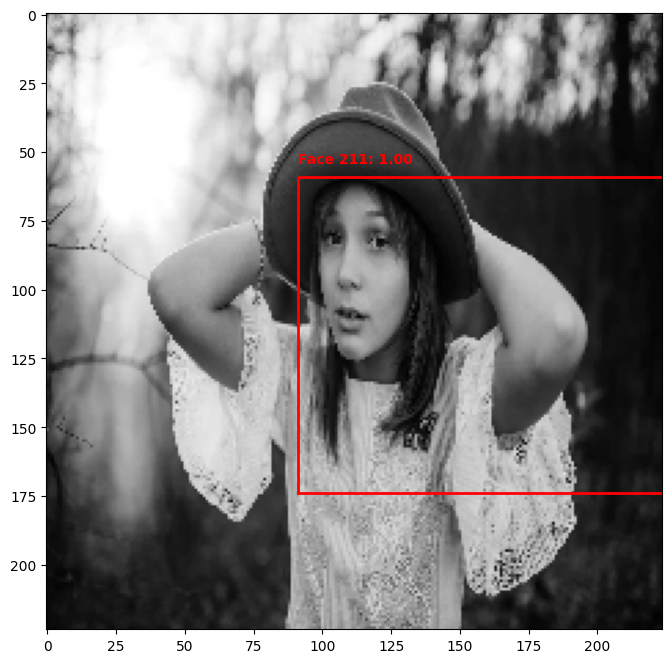

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
0.44494888 0.063616216 0.62871885 0.35940662 0.9999815
Slot 0 - Box: [99.0, 14.0, 140.0, 80.0] Conf: 1.00


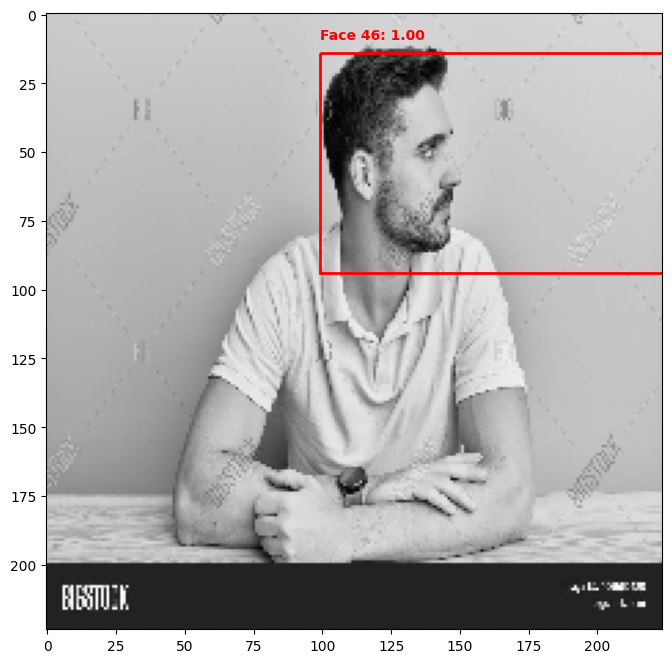

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
0.20765504 0.22023591 0.42983574 0.46547365 0.9980829
Slot 0 - Box: [46.0, 49.0, 96.0, 104.0] Conf: 1.00


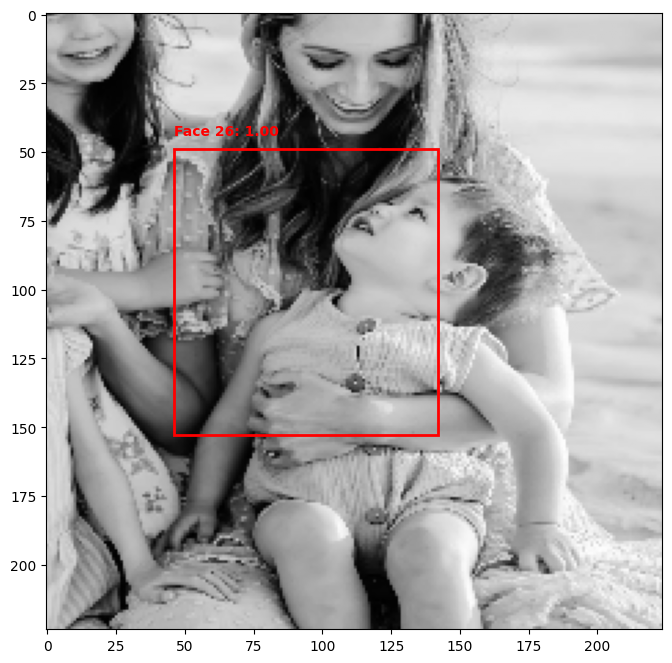

In [ ]:
import matplotlib.patches as patches
import matplotlib.pyplot as plt

def plot_predictions(model, idx, threshold=0.5):
    # 1. Prepare data
    X = X_test[idx].reshape(1, 224, 224, 1)
    img = X_test[idx].reshape(224, 224)
    
    # 2. Predict
    # Result is (1, 12, 5) -> we take [0] to get (12, 5)
    model_prediction = model.predict(X)[0]
    fig, ax = plt.subplots(1, figsize=(8, 8))
    ax.imshow(img, cmap='gray')
    
    # 3. Iterate through the 12 possible face slots
    index = 0
    best_conf = model_prediction[index][-1]

    for i, pred in enumerate(model_prediction):
        x, y, w, h, conf = pred
        if conf >= threshold and conf >= best_conf:
            best_conf = conf
            index = i

    
    x, y, x1, y1, conf = model_prediction[index]
    print(x, y, x1, y1, conf)
    # Scale up to 224x224
    px, py = int(x * 224), int(y * 224)
    px1, py1 = int(x1 * 224), int(y1 * 224)
    
    # patches.Rectangle uses (x, y), width, height
    rect = patches.Rectangle((px, py), px1, py1, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    ax.text(px, py-5, f"Face {idx}: {conf:.2f}", color='red', weight='bold')
    
    print(f"Slot {index} - Box: [{px:.1f}, {py:.1f}, {px1:.1f}, {py1:.1f}] Conf: {conf:.2f}")
    plt.show()

import random
for i in range(10):
    plot_predictions(model, random.randint(1,300))